There are a number of issues I want to discuss in the problem of analysing CRISPR inhibition or CRISPR activation (CRISPRi/a) screens.  Most of this was learned during my postdoc at Stanford, working in the labs of [Stanley Qi](https://med.stanford.edu/qilab.html) and [Wing Hung Wong](https://web.stanford.edu/group/wonglab/).  

# Design

The most prevalant screen design is the classic treatment-control.  The key to this design is to ensure that everything is the same between the treatment and control, except for the the effect you want to measure.  For example, in gene essentiality screens the treatment is CRISPRi or CRISPRko treated and the the control is the untreated population.  However, you need to make sure that everything else between the two conditions are the same.  Another example is drug treatment screens to identify the mechanism or pathways of a drug.  In this case, the CRISPRi/a treatment is applied to both treatment and control.  The difference is that the treatment population is treated with the drug.  

Another design, discussed in the Qi lab's [neuron screen paper](https://www.sciencedirect.com/science/article/pii/S1934590918304405), is to compare positive vs negative selection.  This is particularly relevant in the context of gain of function screens.  In this design, the CRISPRi/a treatment is applied to the population.  Then after the effect is allowed to set in, the population is selected for and against the desired phenotype.  In the neuron screen this was beta-tubulin postive and beta-tubulin negative, respectively.  This design should control for effects of the CRISPR modulation that are not associated with the desired phenotype.  

# Measurement

The outcomes we see from the screen are the counts of sequenced guide RNAs, typically like a table below taken from [Gilbert 2014](https://www.sciencedirect.com/science/article/pii/S0092867414011787).  This is a genome-wide CRISPRi screen for ricin sensitivity/susceptibility.

In [1]:
import sys
!{sys.executable} -m pip install seaborn

You should consider upgrading via the '/Users/tim.daley/git/interviews/engineer/blog/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import seaborn

data_loc = '20150112_ctxdta_crispri_mergedcountstable.txt'
gilbert_2014 = pd.read_csv(data_loc, sep = '\t', header = 0)
gilbert_2014.head()

,sgId,sequence,gene,T0JEV,T0MH,treatedJEV,treatedMH,untreatedJEV,untreatedMH
0,Apoptosis+Cancer+Other_Cancer=A2M_+_9268488.25...,GACCAGATGGATTGTAGGGAGT,A2M,988,1114,813,1116,1131,1050
1,Apoptosis+Cancer+Other_Cancer=A2M_+_9268495.24...,GTTTGGGACCAGATGGATTGT,A2M,587,592,356,526,670,507
2,Apoptosis+Cancer+Other_Cancer=A2M_+_9268513.26...,GCCCAGTTGCTTTGGGAAGTGTT,A2M,843,909,818,721,1057,867
3,Apoptosis+Cancer+Other_Cancer=A2M_+_9268524.25...,GCAGCATAAAGCCCAGTTGCTT,A2M,572,655,848,797,855,690
4,Apoptosis+Cancer+Other_Cancer=A2M_+_9268659.23...,GGGATTCTATTTAGCCCGCC,A2M,431,417,349,396,394,411


In [3]:
import numpy as np

def log2_fc(df, condition_col, control_col, zero_correction = 1):
  # formula is log2(treatment_prob/condition_prob)
  # where x_prob is relative proportion
  # x_prob = (count + zero_correction) / sum(count + zero_correction)
  # more accurate to work in log space
  log_num = np.log2(df[condition_col] + zero_correction) - np.log2(sum(df[condition_col] + zero_correction))
  log_denom = np.log2(df[control_col] + zero_correction) - np.log2(sum(df[control_col] + zero_correction))
  return log_num - log_denom

gilbert_2014['essential_lfc_JEV'] = log2_fc(gilbert_2014, "untreatedJEV", "T0JEV")
gilbert_2014['essential_lfc_MH'] = log2_fc(gilbert_2014, "untreatedMH", "T0MH")
gilbert_2014['ricin_lfc_MH'] = log2_fc(gilbert_2014, "treatedMH", "untreatedMH")
gilbert_2014['ricin_lfc_JEV'] = log2_fc(gilbert_2014, "treatedJEV", "untreatedJEV")

gilbert_2014.head()

,sgId,sequence,gene,T0JEV,T0MH,treatedJEV,treatedMH,untreatedJEV,untreatedMH,essential_lfc_JEV,essential_lfc_MH,ricin_lfc_MH,ricin_lfc_JEV
0,Apoptosis+Cancer+Other_Cancer=A2M_+_9268488.25...,GACCAGATGGATTGTAGGGAGT,A2M,988,1114,813,1116,1131,1050,0.054000,-0.054468,0.121453,-0.336574
1,Apoptosis+Cancer+Other_Cancer=A2M_+_9268495.24...,GTTTGGGACCAGATGGATTGT,A2M,587,592,356,526,670,507,0.049665,-0.192390,0.086561,-0.771189
2,Apoptosis+Cancer+Other_Cancer=A2M_+_9268513.26...,GCCCAGTTGCTTTGGGAAGTGTT,A2M,843,909,818,721,1057,867,0.185193,-0.037358,-0.232110,-0.230205
3,Apoptosis+Cancer+Other_Cancer=A2M_+_9268524.25...,GCAGCATAAAGCCCAGTTGCTT,A2M,572,655,848,797,855,690,0.438244,0.105803,0.241289,0.127353
4,Apoptosis+Cancer+Other_Cancer=A2M_+_9268659.23...,GGGATTCTATTTAGCCCGCC,A2M,431,417,349,396,394,411,-0.270010,0.009955,-0.019919,-0.035298


Text(0.5, 1.0, 'Distribution of essential log2 fold changes')

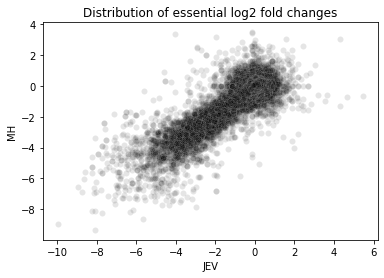

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = seaborn.scatterplot(x = "essential_lfc_JEV", y = "essential_lfc_MH", 
                         data = gilbert_2014, alpha = 0.1, color = 'black')
ax.set_xlabel('JEV')
ax.set_ylabel('MH')
ax.set_title("Distribution of essential log2 fold changes")

Text(0.5, 1.0, 'Distribution of ricin log2 fold changes')

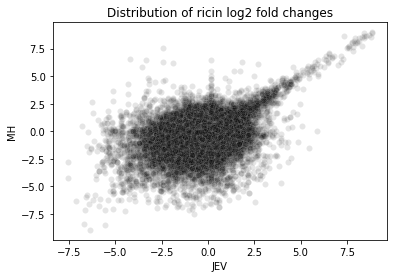

In [5]:
fig, ax = plt.subplots()
ax = seaborn.scatterplot(x = "ricin_lfc_JEV", y = "ricin_lfc_MH", 
                         data = gilbert_2014, alpha = 0.1, color = 'black')
ax.set_xlabel('JEV')
ax.set_ylabel('MH')
ax.set_title("Distribution of ricin log2 fold changes")

We see that the distribution of the log fold changes of the "essential" experiment is towards the negative side, while for the "ricin" experiment it goes both ways but mostly towards the postive side.  This is a definite difference in the experiments.  

# Moderated log fold change

We see a lot of noise in the above plots.  Except for the extreme outliers it's difficult to determine what the signal and what's the noise.  A good solution to this problem is using a moderated log fold change.  There are a number of packages to compute this.  The basic idea behind all of them is to smooth the log fold changes towards zero, accounting for noise from sequencing, usually based on a negative binomial regression.  I particularly like DESeq2, but it's implemented in R. 

In [6]:
import sys
!{sys.executable} -m pip install rpy2

You should consider upgrading via the '/Users/tim.daley/git/interviews/engineer/blog/venv/bin/python -m pip install --upgrade pip' command.


In [7]:
%load_ext rpy2.ipython

In [8]:
import warnings
warnings.filterwarnings('ignore')
%R require(DESeq2); require(ggplot2); 
%Rpush gilbert_2014
%R counts = gilbert_2014[, c(4, 5, 8, 9)]; coldata = data.frame(condition = c(0, 0, 1, 1), rep = c(0, 1, 0, 1)); \
  rownames(coldata) = colnames(counts);\
  WeissmanCRISPRiRicinTreatmentUntreatedVsDay0DESeq = DESeq2::DESeqDataSetFromMatrix(countData = counts, colData = coldata, design = ~ condition);\
  WeissmanCRISPRiRicinTreatmentUntreatedVsDay0DESeq = DESeq2::DESeq(WeissmanCRISPRiRicinTreatmentUntreatedVsDay0DESeq);\
  WeissmanCRISPRiRicinTreatmentUntreatedVsDay0DESeq = DESeq2::results(WeissmanCRISPRiRicinTreatmentUntreatedVsDay0DESeq);\
  log2fc = WeissmanCRISPRiRicinTreatmentUntreatedVsDay0DESeq$log2FoldChange;\
  adj_pvals = WeissmanCRISPRiRicinTreatmentUntreatedVsDay0DESeq$padj
%Rpull log2fc adj_pvals

R[write to console]: Loading required package: DESeq2

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    o

In [9]:
gilbert_2014['essential_moderated_log2fc'] = log2fc
gilbert_2014['essential_moderated_adj_pval'] = adj_pvals
gilbert_2014.head()

,sgId,sequence,gene,T0JEV,T0MH,treatedJEV,treatedMH,untreatedJEV,untreatedMH,essential_lfc_JEV,essential_lfc_MH,ricin_lfc_MH,ricin_lfc_JEV,essential_moderated_log2fc,essential_moderated_adj_pval
0,Apoptosis+Cancer+Other_Cancer=A2M_+_9268488.25...,GACCAGATGGATTGTAGGGAGT,A2M,988,1114,813,1116,1131,1050,0.054000,-0.054468,0.121453,-0.336574,-0.026463,0.999736
1,Apoptosis+Cancer+Other_Cancer=A2M_+_9268495.24...,GTTTGGGACCAGATGGATTGT,A2M,587,592,356,526,670,507,0.049665,-0.192390,0.086561,-0.771189,-0.087428,0.996625
2,Apoptosis+Cancer+Other_Cancer=A2M_+_9268513.26...,GCCCAGTTGCTTTGGGAAGTGTT,A2M,843,909,818,721,1057,867,0.185193,-0.037358,-0.232110,-0.230205,0.052726,0.999736
3,Apoptosis+Cancer+Other_Cancer=A2M_+_9268524.25...,GCAGCATAAAGCCCAGTTGCTT,A2M,572,655,848,797,855,690,0.438244,0.105803,0.241289,0.127353,0.251089,0.536598
4,Apoptosis+Cancer+Other_Cancer=A2M_+_9268659.23...,GGGATTCTATTTAGCCCGCC,A2M,431,417,349,396,394,411,-0.270010,0.009955,-0.019919,-0.035298,-0.156360,0.960393


In [10]:
import warnings
warnings.filterwarnings('ignore')
%R require(DESeq2); require(ggplot2); 
%Rpush gilbert_2014
%R counts = gilbert_2014[, c(8, 9, 6, 7)]; coldata = data.frame(condition = c(0, 0, 1, 1), rep = c(0, 1, 0, 1)); \
  rownames(coldata) = colnames(counts);\
  WeissmanCRISPRiRicinTreatmentDESeq = DESeq2::DESeqDataSetFromMatrix(countData = counts, colData = coldata, design = ~ condition);\
  WeissmanCRISPRiRicinTreatmentDESeq = DESeq2::DESeq(WeissmanCRISPRiRicinTreatmentDESeq);\
  WeissmanCRISPRiRicinTreatmentDESeq = DESeq2::results(WeissmanCRISPRiRicinTreatmentDESeq);\
  log2fc = WeissmanCRISPRiRicinTreatmentDESeq$log2FoldChange;\
  adj_pvals = WeissmanCRISPRiRicinTreatmentDESeq$padj
%Rpull log2fc adj_pvals

R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [11]:
gilbert_2014['ricin_moderated_log2fc'] = log2fc
gilbert_2014['ricin_moderated_adj_pval'] = adj_pvals
gilbert_2014.head()

,sgId,sequence,gene,T0JEV,T0MH,treatedJEV,treatedMH,untreatedJEV,untreatedMH,essential_lfc_JEV,essential_lfc_MH,ricin_lfc_MH,ricin_lfc_JEV,essential_moderated_log2fc,essential_moderated_adj_pval,ricin_moderated_log2fc,ricin_moderated_adj_pval
0,Apoptosis+Cancer+Other_Cancer=A2M_+_9268488.25...,GACCAGATGGATTGTAGGGAGT,A2M,988,1114,813,1116,1131,1050,0.054000,-0.054468,0.121453,-0.336574,-0.026463,0.999736,0.085196,0.984008
1,Apoptosis+Cancer+Other_Cancer=A2M_+_9268495.24...,GTTTGGGACCAGATGGATTGT,A2M,587,592,356,526,670,507,0.049665,-0.192390,0.086561,-0.771189,-0.087428,0.996625,-0.151280,0.974268
2,Apoptosis+Cancer+Other_Cancer=A2M_+_9268513.26...,GCCCAGTTGCTTTGGGAAGTGTT,A2M,843,909,818,721,1057,867,0.185193,-0.037358,-0.232110,-0.230205,0.052726,0.999736,-0.054219,0.990361
3,Apoptosis+Cancer+Other_Cancer=A2M_+_9268524.25...,GCAGCATAAAGCCCAGTTGCTT,A2M,572,655,848,797,855,690,0.438244,0.105803,0.241289,0.127353,0.251089,0.536598,0.358094,0.832268
4,Apoptosis+Cancer+Other_Cancer=A2M_+_9268659.23...,GGGATTCTATTTAGCCCGCC,A2M,431,417,349,396,394,411,-0.270010,0.009955,-0.019919,-0.035298,-0.156360,0.960393,0.150326,0.973473


Let's compare the moderated log fold changes to the average of the individual log fold changes.  

In [12]:
gilbert_2014['ricin_lfc_avg'] = gilbert_2014[['ricin_lfc_MH', 'ricin_lfc_JEV']].mean(axis=1)
gilbert_2014['essential_lfc_avg'] = gilbert_2014[['essential_lfc_JEV', 'essential_lfc_MH']].mean(axis=1)

<AxesSubplot:xlabel='essential_moderated_log2fc', ylabel='essential_lfc_avg'>

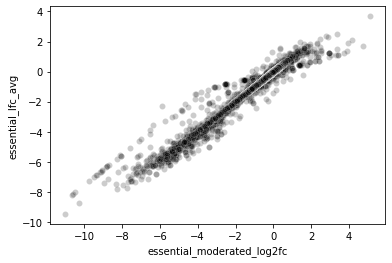

In [13]:
seaborn.scatterplot(x = 'essential_moderated_log2fc', y = 'essential_lfc_avg', 
                    data = gilbert_2014, alpha = 0.2, color = 'black')

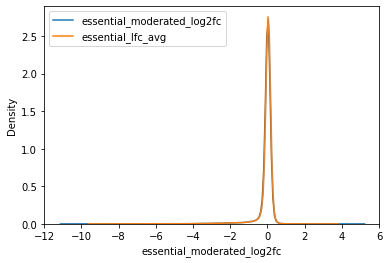

In [14]:
fig, ax = plt.subplots()
for x in ['essential_moderated_log2fc', 'essential_lfc_avg']:
    seaborn.kdeplot(gilbert_2014[x], ax=ax, label = x)
ax.set_xlim(-12, 6)
ax.legend()

<AxesSubplot:xlabel='ricin_moderated_log2fc', ylabel='ricin_lfc_avg'>

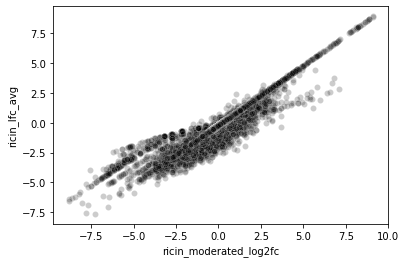

In [15]:
seaborn.scatterplot(x = 'ricin_moderated_log2fc', y = 'ricin_lfc_avg', 
                    data = gilbert_2014, alpha = 0.2, color = 'black')

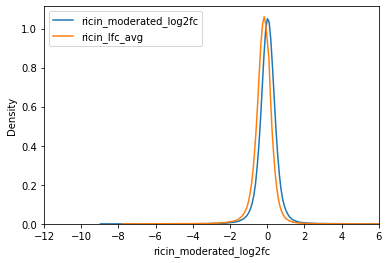

In [16]:
fig, ax = plt.subplots()
for x in ['ricin_moderated_log2fc', 'ricin_lfc_avg']:
    seaborn.kdeplot(gilbert_2014[x], ax=ax, label = x)
ax.set_xlim(-12, 6)
ax.legend()

In [17]:
[gilbert_2014['ricin_moderated_log2fc'].mean(), gilbert_2014['ricin_lfc_avg'].mean()]

[0.024711828301861735, -0.19521762342504134]

Note the difference in means between the moderated log fold change and the average of the individual log fold changes.  The former is close to zero, while the latter seems a bit different than zero.  It's worth checking the distribution of negative control guides. 

In [18]:
gilbert_2014['gene'].value_counts()

negative_control    10569
EIF4G2                 56
EIF5A                  52
MATR3                  50
UBTF                   50
                    ...  
RGS18                   6
GZMK                    6
PTPRQ                   6
ZNF705D                 4
IFNA6                   4
Name: gene, Length: 15976, dtype: int64

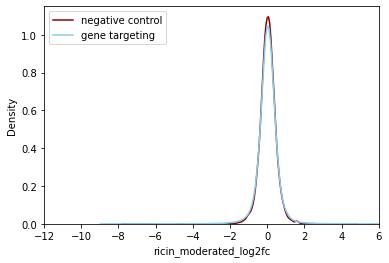

In [19]:
neg_ctrl_flag = (gilbert_2014['gene'] == 'negative_control')

fig, ax = plt.subplots()
seaborn.kdeplot(gilbert_2014[neg_ctrl_flag]['ricin_moderated_log2fc'], ax=ax, 
                label = 'negative control', color = 'darkred')
seaborn.kdeplot(gilbert_2014[~neg_ctrl_flag]['ricin_moderated_log2fc'], ax=ax, 
                label = 'gene targeting', color = 'skyblue')
ax.set_xlim(-12, 6)
ax.legend()

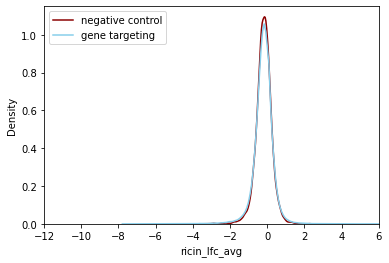

In [20]:
fig, ax = plt.subplots()
seaborn.kdeplot(gilbert_2014[neg_ctrl_flag]['ricin_lfc_avg'], ax=ax, 
                label = 'negative control', color = 'darkred')
seaborn.kdeplot(gilbert_2014[~neg_ctrl_flag]['ricin_lfc_avg'], ax=ax, 
                label = 'gene targeting', color = 'skyblue')
ax.set_xlim(-12, 6)
ax.legend()

# The importance of negative controls

Negative control guides give us an estimate of the null distribution.  It's always good to check the distribution of the negative control guides.  One thing to check is whether the peaks of the gene targeting and the peak of the negative control guides match up.  This validates the assumption that most genes have no effect.  The other main thing to check is if there's a over-representation of the gene targeting guides in the tail in which you expect the signal to lie.  For example, in the essential log fold change we expect an over-representation towards the negative end of the log fold change.  This gives us an assurance that there is a signal present in the data.

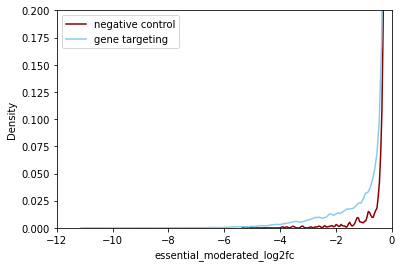

In [21]:
fig, ax = plt.subplots()
seaborn.kdeplot(gilbert_2014[neg_ctrl_flag]['essential_moderated_log2fc'], ax=ax, 
                label = 'negative control', color = 'darkred')
seaborn.kdeplot(gilbert_2014[~neg_ctrl_flag]['essential_moderated_log2fc'], ax=ax, 
                label = 'gene targeting', color = 'skyblue')
ax.set_xlim(-12, 0)
ax.set_ylim(0, 0.2)
ax.legend()

## When the negative control and gene targeting distributions don't match up

A pernicious problem is when the distributions of the negative controls and gene targeting guides don't match up.  I've seen this once before, in our [neuron screen](https://www.sciencedirect.com/science/article/pii/S1934590918304405).  This was an activation screen of transcription factors that led mouse embryonic stem cells to differentiation to neurons.  But there is a perfectly reasonable explanation for this behavior.  If a transcription factor is associated with some cell fate other than neurons then we should expect that those factors would be depleted (compared to the negative control, which have some non-zero base rate of neuron differentation).  This would be true even if a non-negligible number of transcription factors would lead to non-neuronal fates. 

In [22]:
neuron = pd.read_csv('NeuronPerfectMatchCounts.txt', sep = '\t')
neuron.head()

,guide,gene,distance2TSS,plasmid_rep1,plasmid_rep2,CD8_pos_rep1,CD8_neg_rep1,CD8_pos_rep2,CD8_neg_rep2
0,GGGTATCTGGACTAGAAGCC,Sox17,128,249,400,50,196,3,21
1,GTTTGAGTGTGATACCGCTG,Sox17,170,197,287,190,286,363,582
2,GTATCACACTCAAACAGTGC,Sox17,178,539,517,1462,2171,111,193
3,GACCTGAGGCTCGAAAGGCT,Sox17,241,198,278,604,76,11,21
4,GCTGTGCCCGTAACCATTTG,Sox17,291,372,455,184,688,223,159


In [23]:
neuron['gene'].value_counts()

random    8237
Hmga1      825
Nfatc2     807
Aire       632
Tcf3       530
          ... 
Mir15a       9
Gm4736       5
Zfp628       4
Obox3        3
Obox5        2
Name: gene, Length: 824, dtype: int64

In [24]:
# there are micro RNA's in the library.  need to subset to TFs only
mir_flag = neuron['gene'].str.startswith('Mir')
print(mir_flag.value_counts())
print(neuron.shape)
neuron = neuron[~mir_flag]
print(neuron.shape)

False    97388
True      3497
Name: gene, dtype: int64
(100885, 9)
(97388, 9)


In [25]:
neuron['pos_vs_neg_lfc_rep1'] = log2_fc(neuron, "CD8_pos_rep1", "CD8_neg_rep1")
neuron['pos_vs_neg_lfc_rep2'] = log2_fc(neuron, "CD8_pos_rep2", "CD8_neg_rep2")
neuron['pos_vs_neg_lfc_avg'] = neuron[['pos_vs_neg_lfc_rep1', 'pos_vs_neg_lfc_rep2']].mean(axis=1)
neuron.head()

,guide,gene,distance2TSS,plasmid_rep1,plasmid_rep2,CD8_pos_rep1,CD8_neg_rep1,CD8_pos_rep2,CD8_neg_rep2,pos_vs_neg_lfc_rep1,pos_vs_neg_lfc_rep2,pos_vs_neg_lfc_avg
0,GGGTATCTGGACTAGAAGCC,Sox17,128,249,400,50,196,3,21,-1.661383,-2.397803,-2.029593
1,GTTTGAGTGTGATACCGCTG,Sox17,170,197,287,190,286,363,582,-0.299234,-0.617929,-0.458581
2,GTATCACACTCAAACAGTGC,Sox17,178,539,517,1462,2171,111,193,-0.281850,-0.730929,-0.506390
3,GACCTGAGGCTCGAAAGGCT,Sox17,241,198,278,604,76,11,21,3.262249,-0.812840,1.224704
4,GCTGTGCCCGTAACCATTTG,Sox17,291,372,455,184,688,223,159,-1.608735,0.547056,-0.530840


In [26]:
neuron['gene'].value_counts()

random    8237
Hmga1      825
Nfatc2     807
Aire       632
Tcf3       530
          ... 
Mycs        10
Gm4736       5
Zfp628       4
Obox3        3
Obox5        2
Name: gene, Length: 786, dtype: int64

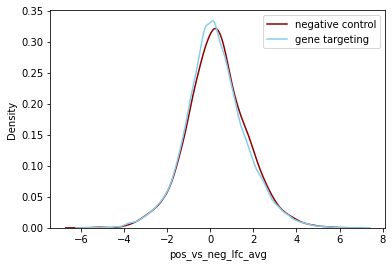

In [27]:
neg_ctrl_flag = (neuron['gene'] == 'random')

fig, ax = plt.subplots()
seaborn.kdeplot(neuron[neg_ctrl_flag]['pos_vs_neg_lfc_avg'], ax=ax, 
                label = 'negative control', color = 'darkred')
seaborn.kdeplot(neuron[~neg_ctrl_flag]['pos_vs_neg_lfc_avg'], ax=ax, 
                label = 'gene targeting', color = 'skyblue')
ax.legend()

The solution proposed by [Salil Bhate](https://www.linkedin.com/in/salil-bhate-4a115ba8/) was to calcaulte a score of the enrichment of the gene targeting guides compared to the negative controls.

In [28]:
import random 
import statistics

def enrich_score(scores, neg_ctrl_scores):
    assert(len(scores) == len(neg_ctrl_scores))
    return(statistics.mean(scores) - statistics.mean(neg_ctrl_scores))

def cal_enrich(gene_targeting_guides, neg_ctrl_guides, n_bootstraps = 10000):
    n_gene = len(gene_targeting_guides)
    samples_scores = []
    for i in range(n_bootstraps):
        neg_ctrl_sample = random.sample(neg_ctrl_guides, n_gene)
        samples_scores.append(enrich_score(gene_targeting_guides, neg_ctrl_sample))
    return statistics.mean(samples_scores)

g = 'Gm4736'
guides = neuron[neuron['gene'] == g]['pos_vs_neg_lfc_avg'].tolist()
print(len(guides))
print(guides)

neg_ctrl_guides = neuron[neuron['gene'] == 'random']['pos_vs_neg_lfc_avg'].tolist()
print(len(neg_ctrl_guides))

neg_ctrl_sample = random.sample(neg_ctrl_guides, len(guides))
print(len(neg_ctrl_sample))
print(neg_ctrl_sample)

cal_enrich(neuron[neuron['gene'] == g]['pos_vs_neg_lfc_avg'].tolist(),
           neuron[neuron['gene'] == 'random']['pos_vs_neg_lfc_avg'].tolist())

5
[-0.051638582979339986, -0.5709901880241777, 0.17943040819011102, 0.17943040819011102, 0.5476740973761256]
8237
5
[-1.5268412000817353, 3.888907026395401, 2.5909816179634557, 0.9260165549450683, -0.3309388391867021]


-0.2631524074368839

In [29]:
genes = neuron['gene'].unique().tolist()
genes.remove('random')
print(len(genes))
gene_scores = pd.DataFrame({'gene': genes})
gene_scores['score'] = \
  gene_scores['gene'].map(lambda g: cal_enrich(neuron[neuron['gene'] == g]['pos_vs_neg_lfc_avg'].tolist(),
                                               neuron[neuron['gene'] == 'random']['pos_vs_neg_lfc_avg'].tolist()))
gene_scores['n_guides'] = gene_scores['gene'].map(lambda g: sum(neuron['gene'] == g))
gene_scores.head()

785


,gene,score,n_guides
0,Sox17,-0.347266,252
1,Mybl1,-0.426841,48
2,Ncoa2,-0.432888,72
3,Msc,0.169258,60
4,Arid5a,-0.015604,237


In [30]:
gene_scores.sort_values(by = 'score', ascending = False).head(30)

,gene,score,n_guides
216,Obox5,2.404559,2
86,Snai1,1.029969,82
205,Zfp239,0.926932,40
6,Pou3f3,0.874267,60
201,Pcbp1,0.818536,40
280,Zfp423,0.815143,138
212,Zfp628,0.812128,4
500,Pcbp2,0.794597,65
572,Foxd4,0.763076,38
604,Pax3,0.731000,141


<AxesSubplot:>

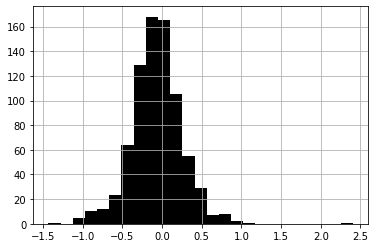

In [31]:
gene_scores['score'].hist(bins = 25, color = 'black')

In [32]:
gene_scores['score'].median()

-0.06582876582313937

We see a lot of these genes overlap with the original list, though it doesn't correspond exactly.  But that's not totally unexpected.  We also see that the median of the gene scores is slightly negative, which means that most gene scores are negative.  We cannot assume there that a null gene has zero effect, relative to the negative controls.  Instead most genes have a negative effect.  Seems strange, but it can trip you up.  


Sorry for the aside, let's return to the Gilbert data. 

# Combining guide level measurements 

We now come to the problem of how to combine information at the guide level to make inferences at the gene level.  Simple methods, such as taking the mean of the guide-level log fold changes will ignore issues such as non-working guides or off-target effects.

With these types of screens it's difficult to know the ground truth.  We usually have to use proxy information in order to judge how good our inferences are, such as GO terms of the top hits.  Essential screens are pretty well studied.  [Hart et al, 2014](https://www.embopress.org/doi/pdf/10.15252/msb.20145216) compiled a list of common essential genes across a number of a number of different studies.  We can use this as a "ground truth" to compare different methods. 

In [33]:
essential_genes = pd.read_csv("core-essential-genes-sym_HGNCID.txt", sep = '\t', 
                              header = None, names = ['gene', 'hgnc'])
print(essential_genes.shape)
essential_genes.head()

(1580, 2)


,gene,hgnc
0,AAMP,HGNC:18
1,AARS2,HGNC:21022
2,AARS,HGNC:20
3,AASDHPPT,HGNC:14235
4,AATF,HGNC:19235


In [34]:
sum(essential_genes['gene'].isin(gilbert_2014['gene']))

1561

## Combining p-values

There's a few ways to combine p-values.  [Fisher's method](https://en.wikipedia.org/wiki/Fisher%27s_method), [Stouffer's method](https://en.wikipedia.org/wiki/Fisher%27s_method#Relation_to_Stouffer's_Z-score_method), and [robust rank aggregation](https://academic.oup.com/bioinformatics/article/28/4/573/213339) (which MAGeCK uses).  Let's compare them.  But one thing to account for is that the default implementation of Stouffer's method in [scipy.stats](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.combine_pvalues.html) won't distinguish the two sided p-values.  So we need to do it ourselves.  

In [35]:
import scipy.stats as stats
import math

def stouffers_method(pvals, orig_z_vals):
    assert(pvals.shape == orig_z_vals.shape)
    # convert p-values to z_values
    # don't know why scipy uses point percent function to refer to the quantile function
    transformed_zvals = np.sign(orig_z_vals)*pvals.map(lambda p: stats.norm.ppf(p/2.0))
    z = sum(transformed_zvals)/math.sqrt(pvals.shape[0])
    # the absolute value of the z-value is half-normally distributed
    # P(x > |z|) = 1 - 2*(phi(|z|) - 0.5)
    return 1.0 - 2.0*(stats.norm.cdf(abs(z)) - 0.5)

# test if opposite signs cancel
def test_stouffers():
    test_pvals = pd.Series([0.05, 0.05])
    test_zvals = pd.Series([-2.16, 2.16])
    return stouffers_method(test_pvals, test_zvals)
test_stouffers()  



1.0

In [36]:
gilbert_gene_lvl = pd.DataFrame({'gene': gilbert_2014['gene'].unique().tolist()})
gilbert_gene_lvl['essential_stouffer_pval'] = gilbert_gene_lvl['gene'].map(lambda g: stouffers_method(gilbert_2014[gilbert_2014['gene'] == g]['essential_moderated_adj_pval'], 
                                                                                                      gilbert_2014[gilbert_2014['gene'] == g]['essential_moderated_log2fc']))
gilbert_gene_lvl.head()

,gene,essential_stouffer_pval
0,A2M,8.509142e-01
1,A4GALT,6.993867e-01
2,AACS,3.940236e-01
3,AATF,7.682743e-14
4,ABCA13,7.684682e-01


In [37]:
from scipy.stats import combine_pvalues

fishers_pvals = gilbert_2014[['gene', 'essential_moderated_adj_pval']].groupby('gene', as_index = False)\
                                                                      .agg(lambda p: combine_pvalues(p)[1])
fishers_pvals.rename(columns = {'essential_moderated_adj_pval': 'essential_fisher_pval'},
                     inplace = True)
fishers_pvals.head()

,gene,essential_fisher_pval
0,1-Dec,0.999999
1,1-Mar,1.000000
2,1-Sep,0.995081
3,10-Mar,NaN
4,10-Sep,1.000000


In [38]:
print(gilbert_gene_lvl.shape)
gilbert_gene_lvl = gilbert_gene_lvl.merge(fishers_pvals, on = 'gene', how = 'inner')
print(gilbert_gene_lvl.shape)
gilbert_gene_lvl.head()

(15976, 2)
(15976, 3)


,gene,essential_stouffer_pval,essential_fisher_pval
0,A2M,8.509142e-01,1.000000e+00
1,A4GALT,6.993867e-01,1.000000e+00
2,AACS,3.940236e-01,9.959100e-01
3,AATF,7.682743e-14,1.081587e-27
4,ABCA13,7.684682e-01,1.000000e+00


In [39]:
# I noticed N/A's above.  Let's see if they're identical
print("number with stouffer N/A: ", sum(gilbert_gene_lvl['essential_stouffer_pval'].isna()))
print("number with fisher N/A: ", sum(gilbert_gene_lvl['essential_fisher_pval'].isna()))
print("number with both N/A: ", sum(gilbert_gene_lvl['essential_fisher_pval'].isna() & \
                                    gilbert_gene_lvl['essential_stouffer_pval'].isna()))

number with stouffer N/A:  1063
number with fisher N/A:  1063
number with both N/A:  1063


Cool!  Looks like the missing p-values are the same for both method.  Let's see if we can figure out why.

In [40]:
gilbert_gene_lvl[gilbert_gene_lvl['essential_stouffer_pval'].isna()].head()

,gene,essential_stouffer_pval,essential_fisher_pval
139,ANGPT2,NaN,NaN
187,ARID1A,NaN,NaN
453,CD40LG,NaN,NaN
821,DUX4,NaN,NaN
871,ELN,NaN,NaN


In [41]:
gilbert_2014[gilbert_2014['gene'].isin(['ANGPT2', 'ARID1A', 'CD40LG'])]

,sgId,sequence,gene,T0JEV,T0MH,treatedJEV,treatedMH,untreatedJEV,untreatedMH,essential_lfc_JEV,essential_lfc_MH,ricin_lfc_MH,ricin_lfc_JEV,essential_moderated_log2fc,essential_moderated_adj_pval,ricin_moderated_log2fc,ricin_moderated_adj_pval,ricin_lfc_avg,essential_lfc_avg
1718,Apoptosis+Cancer+Other_Cancer=ANGPT2_+_6420678...,GACACAGCCCTCCCAAGTGAGC,ANGPT2,625,689,641,569,738,704,0.098580,0.061840,-0.273075,-0.063802,0.054315,0.999736,0.012386,0.997272,-0.168438,0.080210
1719,Apoptosis+Cancer+Other_Cancer=ANGPT2_+_6420729...,GGATCTGGGGAGAGAGGAACAA,ANGPT2,642,585,346,587,783,622,0.145203,0.119145,-0.049830,-1.036719,0.108920,0.987145,-0.327465,0.917055,-0.543274,0.132174
1720,Apoptosis+Cancer+Other_Cancer=ANGPT2_+_6420737...,GACACTGTAGGATCTGGGGAGAG,ANGPT2,470,567,744,298,571,670,0.139456,0.271235,-1.132581,0.520425,0.184226,0.897740,0.016118,0.997709,-0.306078,0.205346
1721,Apoptosis+Cancer+Other_Cancer=ANGPT2_+_6420746...,GATACTGACACTGTAGGATC,ANGPT2,675,930,652,448,819,890,0.137769,-0.032542,-0.955124,-0.189341,0.017666,0.999736,-0.370208,0.870948,-0.572233,0.052613
1722,Apoptosis+Cancer+Other_Cancer=ANGPT2_+_6420752...,GATTCGGATACTGACACTGT,ANGPT2,1807,1810,1582,1603,2188,1974,0.135046,0.155879,-0.266592,-0.328411,0.119888,0.784776,-0.120716,0.963820,-0.297502,0.145463
1723,Apoptosis+Cancer+Other_Cancer=ANGPT2_+_6420789...,GCTCTTATCAACTTATCATATA,ANGPT2,0,0,0,0,0,0,-0.140832,0.030813,0.033586,0.139199,NaN,NaN,NaN,NaN,0.086393,-0.055009
1724,Apoptosis+Cancer+Other_Cancer=ANGPT2_-_6420667...,GTAAACTGTCAGATTGCAG,ANGPT2,709,760,628,568,813,906,0.056378,0.284019,-0.639088,-0.232769,0.148588,0.901040,-0.260508,0.915055,-0.435928,0.170199
1725,Apoptosis+Cancer+Other_Cancer=ANGPT2_-_6420691...,GAAGAACAGTCCTGCTCACTT,ANGPT2,395,392,314,588,458,469,0.072162,0.288945,0.359193,-0.403943,0.155260,0.956851,0.218926,0.963503,-0.022375,0.180553
1726,Apoptosis+Cancer+Other_Cancer=ANGPT2_-_6420832...,GATAAGAGCAGCCAGACATGTGTAG,ANGPT2,1204,1283,843,1148,1221,1077,-0.120621,-0.221475,0.125608,-0.394730,-0.195593,0.447121,0.056322,0.990337,-0.134561,-0.171048
1727,Apoptosis+Cancer+Other_Cancer=ANGPT2_-_6420833...,GAGCAGCCAGACATGTGTAGT,ANGPT2,1313,1269,1010,1188,1442,1313,-0.005726,0.079950,-0.110630,-0.374089,0.010341,0.999736,-0.061964,0.987661,-0.242360,0.037112


Looks like I forgot to remove the entries with all zeros.  Whoops.  We can remove these rows are redo the calculations.  

In [42]:
print(gilbert_2014.shape)
gilbert_2014_no_zeros = gilbert_2014[(gilbert_2014[['T0JEV', 'T0MH', 'treatedJEV', 'treatedMH', 'untreatedJEV', 
                                                    'untreatedMH']].apply(lambda row: sum(row), axis = 1) > 10)]
print(gilbert_2014_no_zeros.shape)
gilbert_gene_lvl = pd.DataFrame({'gene': gilbert_2014_no_zeros['gene'].unique().tolist()})
gilbert_gene_lvl['essential_stouffer_pval'] = gilbert_gene_lvl['gene'].map(lambda g: stouffers_method(gilbert_2014_no_zeros[gilbert_2014_no_zeros['gene'] == g]['essential_moderated_adj_pval'], 
                                                                                                      gilbert_2014_no_zeros[gilbert_2014_no_zeros['gene'] == g]['essential_moderated_log2fc']))
fishers_pvals = gilbert_2014_no_zeros[['gene', 'essential_moderated_adj_pval']].groupby('gene', as_index = False)\
                                                                      .agg(lambda p: combine_pvalues(p)[1])
fishers_pvals.rename(columns = {'essential_moderated_adj_pval': 'essential_fisher_pval'},
                     inplace = True)
gilbert_gene_lvl = gilbert_gene_lvl.merge(fishers_pvals, on = 'gene', how = 'inner')
print(gilbert_gene_lvl.shape)
print("number with stouffer N/A: ", sum(gilbert_gene_lvl['essential_stouffer_pval'].isna()))
print("number with fisher N/A: ", sum(gilbert_gene_lvl['essential_fisher_pval'].isna()))
print("number with both N/A: ", sum(gilbert_gene_lvl['essential_fisher_pval'].isna() & \
                                    gilbert_gene_lvl['essential_stouffer_pval'].isna()))

(209065, 19)
(207537, 19)
(15976, 3)
number with stouffer N/A:  0
number with fisher N/A:  0
number with both N/A:  0


0.8828464352628952


<AxesSubplot:xlabel='essential_fisher_pval', ylabel='essential_stouffer_pval'>

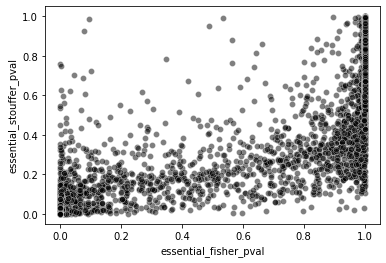

In [43]:
print(gilbert_gene_lvl['essential_fisher_pval'].corr(gilbert_gene_lvl['essential_stouffer_pval']))
seaborn.scatterplot(x = 'essential_fisher_pval', y = 'essential_stouffer_pval', 
                    data = gilbert_gene_lvl, alpha = 0.5, color = 'black')

It looks like when the Stouffer value is high, the Fisher value is also high.  However, when the Fisher value is high it's not necessarily true that the Stouffer value is high.  This is likely because of the issues I've discussed before (https://timydaley.github.io/FisherVsStouffer.html) with Fisher's method in that it doesn't reward signals with a consistent direction and it's susceptibility to off-target and outlier effects.

In [44]:
# top genes
gilbert_gene_lvl.sort_values(by = 'essential_fisher_pval', ascending = True).head(20)

,gene,essential_stouffer_pval,essential_fisher_pval
11197,SUPV3L1,0.0,0.0
1741,NBAS,0.0,0.0
15162,METTL16,0.0,0.0
4245,METAP2,0.0,0.0
6708,RTF1,0.0,0.0
3961,HSD17B10,0.0,0.0
8815,ABCB7,0.0,0.0
6428,ORC5,0.0,0.0
12114,CLNS1A,0.0,0.0
11227,TBCD,0.0,0.0


In [45]:
gilbert_gene_lvl.sort_values(by = 'essential_stouffer_pval', ascending = True).head(20)

,gene,essential_stouffer_pval,essential_fisher_pval
1676,MRPS35,0.0,2.133178e-166
765,DHX16,0.0,6.340320e-118
4335,NARS2,0.0,7.454323e-33
10724,PRPF8,0.0,1.646771e-111
768,DICER1,0.0,2.090871e-152
10722,PRPF3,0.0,1.430806e-155
11793,ACTR10,0.0,1.286949e-80
772,DIS3,0.0,2.115976e-36
10710,PPWD1,0.0,8.043431e-91
8689,TMEM261,0.0,6.947308e-28


Now we can test the performance using the essential gene list from [Hart et al 2014](https://www.embopress.org/doi/pdf/10.15252/msb.20145216).  This was generated from separate RNAi screens across multiple cell lines (probably including K562 because it's the most common cell line).  

In [47]:
essential_genes = pd.read_csv("core-essential-genes-sym_HGNCID.txt", header = None, 
                              sep = '\t', names = ['gene', 'hgnc'])
essential_genes.head()

,gene,hgnc
0,AAMP,HGNC:18
1,AARS2,HGNC:21022
2,AARS,HGNC:20
3,AASDHPPT,HGNC:14235
4,AATF,HGNC:19235


In [48]:
sum(essential_genes['gene'].isin(gilbert_gene_lvl['gene']))

1561

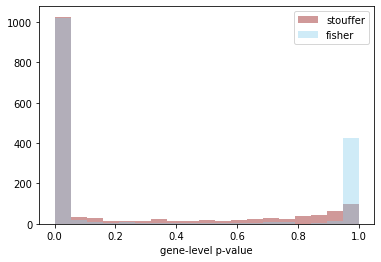

In [51]:
essential_gene_mask = (gilbert_gene_lvl['gene'].isin(essential_genes['gene']))
fig, ax = plt.subplots()
seaborn.distplot(gilbert_gene_lvl[essential_gene_mask]['essential_stouffer_pval'], 
                 ax = ax, color = 'darkred', label = 'stouffer', kde = False, bins = np.linspace(0, 1, 20))
seaborn.distplot(gilbert_gene_lvl[essential_gene_mask]['essential_fisher_pval'], 
                 ax = ax, color = 'skyblue', label = 'fisher', kde = False, bins = np.linspace(0, 1, 20))
ax.set_xlabel('gene-level p-value')
ax.legend()

Looks like the fisher and stouffer agree on the clear signal genes, while stouffer shows lower p-values for a large number of genes that fisher is uncertain about.  What about the "non-essential" genes?  I put non-essential in quotes because we don't actually know if they are non-essential or not, but the majority should be. 

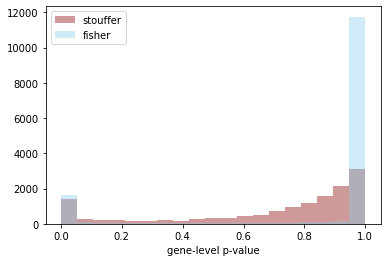

In [52]:
fig, ax = plt.subplots()
seaborn.distplot(gilbert_gene_lvl[~essential_gene_mask]['essential_stouffer_pval'], 
                 ax = ax, color = 'darkred', label = 'stouffer', kde = False, bins = np.linspace(0, 1, 20))
seaborn.distplot(gilbert_gene_lvl[~essential_gene_mask]['essential_fisher_pval'], 
                 ax = ax, color = 'skyblue', label = 'fisher', kde = False, bins = np.linspace(0, 1, 20))
ax.set_xlabel('gene-level p-value')
ax.legend()

Interesting that Fisher's method is very bimodal, while Stouffer's method is a lot more smooth.  This is one reason why I prefer Stouffer's.  

